# Introduction

*spotter* is a package to compute forward models of fluxes and spectra time-series of non-uniform stars. 

Its main advantage over other frameworks is its capability to model small scale features thanks to the surface being subdivided into equal-area pixels. In order to do that, *spotter* exploits the  [HEALPix](https://HEALPix.jpl.nasa.gov/) subdivision scheme (through the python package [*healpy*](https://healpy.readthedocs.io/en/latest/)).

Here is an introduction on how to define a stellar surface with spotter.


## Star object

We can define a [Star](spotter.star.Star) object that will contain the map of the star plus some of its parameters such as limb darkening

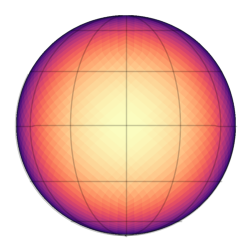

In [1]:
import matplotlib.pyplot as plt
from spotter import Star, show

star = Star.from_sides(16, u=(0.5, 0.2))

plt.figure(figsize=(3, 3))
show(star)

As you can see, we defined the map using a number of sides, not pixels, which is how maps are defined in the HEALPix grid. Check out the [HEALPix documentation](https://healpix.jpl.nasa.gov/index.shtml) for more information.

## Map pixels values

The pixels value of a star can be directly accessed with 

In [2]:
star.y

Array([[1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

The shape of this array is  *(wavelength, pixels)*, with the first dimension being for the wavelength axis. Using JAX, here is how we would set a specific pixel `i` to a certain value.

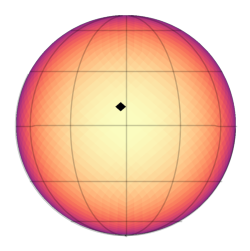

In [3]:
i = 1248

new_y = star.y.at[0, i].set(0.0)
star = star.set(y=new_y)

plt.figure(figsize=(3, 3))
show(star)

## Spots

As an example let's define a map with some spots on it. We will first define a surface with more pixels, a non-zero inclination and a rotation period

In [4]:
import numpy as np

star = star.from_sides(50, inc=1.3, u=(0.5, 0.2), period=1.0)

Let's now add some noise, a spot and faculae

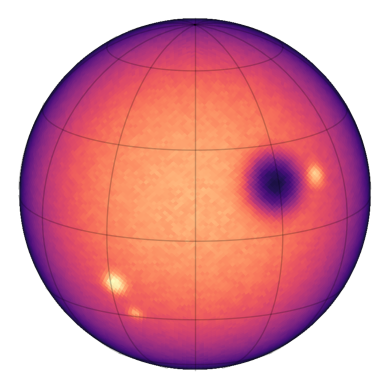

In [5]:
star = star.set(y=1 + 0.05 * np.random.rand(star.size))  # noise
star = star.set(y=star.y - 0.6 * star.spot(0.3, 0.5, 0.15, 25))  # spot

faculae = np.sum(
    [
        star.spot(0.3, 0.8, 0.05, 60) * 0.3 * star.y,
        star.spot(-0.3, -0.5, 0.06, 60) * 0.35 * star.y,
        star.spot(-0.5, -0.4, 0.03, 60) * 0.3 * star.y,
    ],
    0,
)

star = star.set(y=star.y + faculae)

show(star)

## Light curves

Once a surface defined, spotter can be used to compute its light curve.

In [ ]:
import jax
from spotter.light_curves import light_curve

time = np.linspace(0, star.period, 200)

plt.plot(time, light_curve(star, time)[0])
plt.xlabel("phase")
_ = plt.ylabel("flux")

```{note}
All functions in *spotter* are carefully implemented with [JAX](https://jax.readthedocs.io/en/latest/quickstart.html), meaning that they can be vectorized and run on GPUs. For example this could be useful to evaluate the flux of a very large number of maps.
```

spotter can also be used to compute the light curve of a transited star

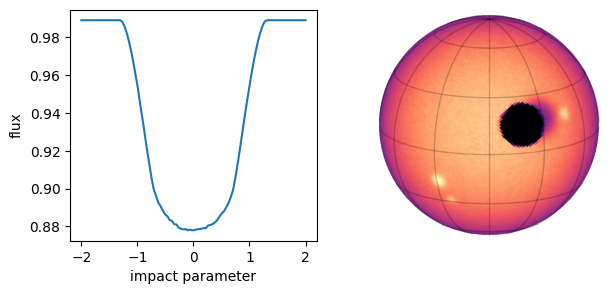

In [ ]:
from spotter.star import transited_star
from spotter.light_curves import transit_light_curve

# impact parameter
b = np.linspace(-2, 2, 100)

flux = jax.vmap(lambda b: transit_light_curve(star, y=b, r=0.3)[0])(b)

plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.plot(b, flux)
plt.xlabel("impact parameter")
plt.ylabel("flux")

plt.subplot(122)
show(transited_star(star, y=0.3, r=0.2))

```{important}
As you can see the transit light curve model contains errors due to the pixelization of the star. This is why *spotter* is considered an **approximate** model only. Check out [this page](./precision.ipynb) for more details about *spotter*'s precision.
```

## JAX and *spotter* core functions

Using spotter core functions directly, other observables can be computed as well. Here are some examples

### Ensemble of rotation light curves

In [ ]:
from spotter import distributions
from spotter.core import amplitude, spot

# number of healpix sides
N = 16

# generate maps with a single random spot
n_spots = 500
key = jax.random.PRNGKey(0)
lats = distributions.latitude_uniform_pdf(key, (n_spots,))
lons = np.random.uniform(0, 2 * np.pi, n_spots)
radii = np.random.uniform(0.01, 0.9, n_spots)
contrast = np.random.uniform(0.01, 0.9, n_spots)
ys = 1 - jax.vmap(jax.jit(spot, static_argnums=(0,)), in_axes=(None, 0, 0, 0))(
    N, lats, lons, radii
)

amplitude = jax.jit(amplitude(N, u=star.u[0]))
values = amplitude(ys)

Here we evaluated the amplitude of the rotational light curves of 500 maps, each containing a single random spot. Let's estimate the processing time of this computation

In [ ]:
%timeit amplitude(ys)

693 μs ± 12.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


i.e. about tens of $\mu s$ per unique map!

```{note}
Notice here how we didn't use the [Star](spotter.star.Star) object at all. Sometimes, especially when dealing with a large number of stars, *spotter*'s objects are not as optimal as working directly with the stellar maps, especially when using JAX transforms.
```

### Stellar contamination estimates

Other features of *spotter* are useful to compute the spot coverage, either of the map itself

In [ ]:
# trivial
spotted = star.y < 1.0
coverage = np.mean(spotted)

print(f"coverage: {coverage * 100:.2f}%")

coverage: 1.98%


or within a specific transit chord

chord coverage: 20.59%


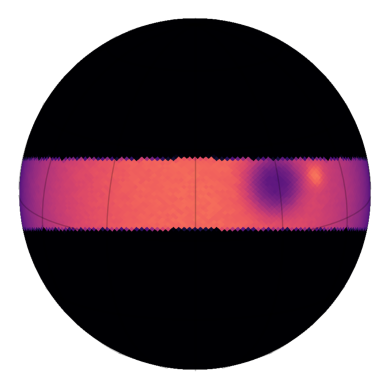

In [ ]:
from spotter.core import mask_projected_limb, transit_chord, vec

transit = transit_chord(star.N, 0.0, 0.2, star.inc)

mask, area, _ = mask_projected_limb(vec(star.N), u=star.u[0], inc=star.inc)

spotted = (star.y[0] < 1.0) * mask
transited = transit * mask > 0.0

# let's show the chord
show(star * transited, vmin=0.0, vmax=1.5)

# covering fraction in the chord
chord_coverage = (spotted * transited * area).sum() / (transited * area).sum()
print(f"chord coverage: {chord_coverage * 100:.2f}%")

which is useful to compute transmission spectroscopy stellar contamination effects.